# Impact of Academic Factors on Final Grades

The test below looks into.......

## Features Related to Academic Factors

### Independent Variables: 
**studytime** - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours) <br>
**failures** - number of past class failures (numeric: n if 1<=n<3, else 4) <br>
**schoolsup** - extra educational support (binary: yes or no) <br>
**famsup** - family educational support (binary: yes or no) <br>
**paid** - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no) <br>
**higher** - wants to take higher education (binary: yes or no)<br>

### Dpendent Variables: 
**G1** - first period grade (numeric: from 0 to 20) <br>
**G2** - second period grade (numeric: from 0 to 20) <br>
**G3** - final grade (numeric: from 0 to 20, output target) <br>

In [92]:
# Import libraries
import pandas as pd
import math
from matplotlib import gridspec
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [66]:
# Read in the datasets
students_mat = pd.read_csv('../dataset/student-mat.csv', delimiter=';')
students_por = pd.read_csv('../dataset/student-por.csv', delimiter=';')

# Merge common students
mat_students = students_mat.merge(students_por[["school","sex","age","address","famsize","Pstatus","Medu","Fedu","Mjob","Fjob","reason","nursery","internet"]])
por_students = students_por.merge(students_mat[["school","sex","age","address","famsize","Pstatus","Medu","Fedu","Mjob","Fjob","reason","nursery","internet"]])

# Filter out for academic features
mat_students = mat_students[['studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'higher', 'G1', 'G2', 'G3']]
por_students = por_students[['studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'higher', 'G1', 'G2', 'G3']]

In [67]:
mat_students.head(3) # View the math dataset

,studytime,failures,schoolsup,famsup,paid,higher,G1,G2,G3
0,2,0,yes,no,no,yes,5,6,6
1,2,0,no,yes,no,yes,5,5,6
2,2,3,yes,no,yes,yes,7,8,10


In [77]:
mat_students.describe().applymap('{:,.2f}'.format).T # descriptive statistics for mat class

,count,mean,std,min,25%,50%,75%,max
studytime,382.00,2.03,0.85,1.00,1.00,2.00,2.00,4.00
failures,382.00,0.29,0.73,0.00,0.00,0.00,0.00,3.00
G1,382.00,10.86,3.35,3.00,8.00,10.50,13.00,19.00
G2,382.00,10.71,3.83,0.00,8.25,11.00,13.00,19.00
G3,382.00,10.39,4.69,0.00,8.00,11.00,14.00,20.00


In [69]:
por_students.head(3) # View the por dataset

,studytime,failures,schoolsup,famsup,paid,higher,G1,G2,G3
0,2,0,yes,no,no,yes,0,11,11
1,2,0,no,yes,no,yes,9,11,11
2,2,0,yes,no,no,yes,12,13,12


In [78]:
por_students.describe().applymap('{:,.2f}'.format).T # descriptive statistics for por class

,count,mean,std,min,25%,50%,75%,max
studytime,382.00,2.04,0.85,1.00,1.00,2.00,2.00,4.00
failures,382.00,0.14,0.51,0.00,0.00,0.00,0.00,3.00
G1,382.00,12.11,2.56,0.00,10.00,12.00,14.00,19.00
G2,382.00,12.24,2.47,5.00,11.00,12.00,14.00,19.00
G3,382.00,12.52,2.95,0.00,11.00,13.00,14.00,19.00


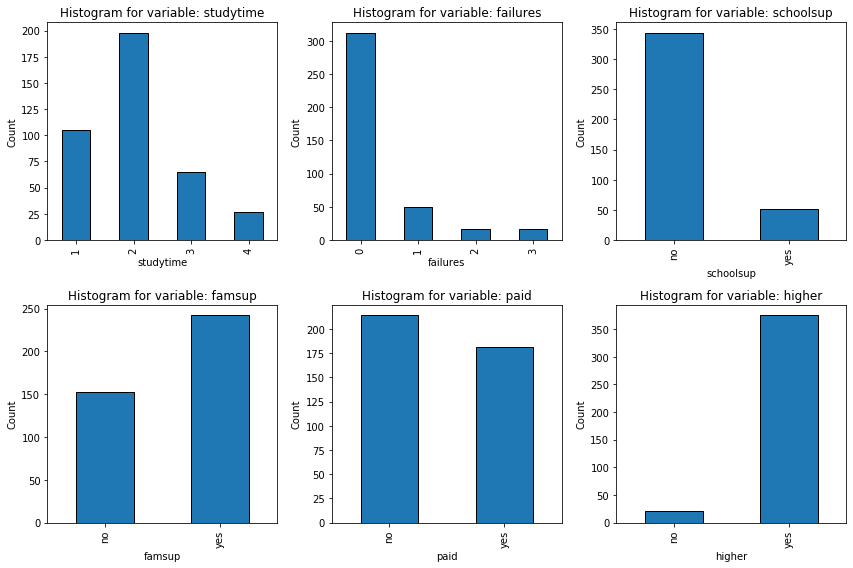

In [85]:
# Plot frequency distributions for each independent variable
columns = ['studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'higher'] # independent variables
n_plots = len(columns)   
gs = gridspec.GridSpec(2, 3)
fig = plt.figure(figsize=(12,8))
for i in range(n_plots):
    ax = fig.add_subplot(gs[i])
    students_mat[columns[i]].value_counts().sort_index().plot(kind='bar', ax=ax, edgecolor='black')
    ax.set_xlabel(columns[i])
    ax.set_ylabel('Count')
    ax.set_title('Histogram for variable: ' + columns[i])
fig.tight_layout()
plt.show()

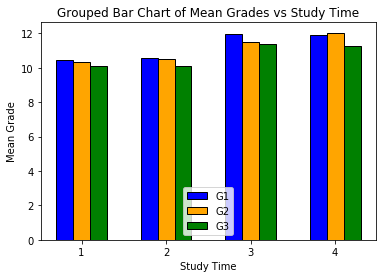

In [111]:
# Grouped bar chart of mean grades per study time group
studytime = [1, 2, 3, 4]
width = 0.2
for x in studytime:
    y1 = mat_students.loc[mat_students['studytime'] == x]['G1'].mean()
    y2 = mat_students.loc[mat_students['studytime'] == x]['G2'].mean()
    y3 = mat_students.loc[mat_students['studytime'] == x]['G3'].mean()
    plt.bar(x-0.2, y1, width, color='blue', edgecolor='black') 
    plt.bar(x, y2, width, color='orange', edgecolor='black') 
    plt.bar(x+0.2, y3, width, color='green', edgecolor='black') 

plt.xticks(studytime) 
plt.xlabel("Study Time") 
plt.ylabel("Mean Grade")
plt.title("Grouped Bar Chart of Mean Grades vs Study Time")
plt.legend(["G1", "G2", "G3"], loc='lower center') 
plt.show() 